In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [30]:
base_path = '/Users/vamshisamudrala/Downloads/lung_colon_image_set'

In [31]:
IMG_SIZE = 150

X = []
Z = []

In [32]:
def assign_label(img, category):
    return category

def make_train_data(category, DIR):
    for img in os.listdir(DIR):
        label = assign_label(img, category)
        path = os.path.join(DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_COLOR)
        
        if img_data is not None:
            img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
            X.append(np.array(img_data))  
            Z.append(str(label)) 
        else:
            print(f"Error reading image: {path}")

In [33]:
COLON_ACA_DIR = os.path.join(base_path, 'colon_aca')
COLON_N_DIR = os.path.join(base_path,'colon_n')
LUNG_ACA_DIR = os.path.join(base_path, 'lung_aca')
LUNG_N_DIR = os.path.join(base_path, 'lung_n')
LUNG_SCC_DIR = os.path.join(base_path, 'lung_scc')

In [34]:
make_train_data('colon_aca', COLON_ACA_DIR)
make_train_data('colon_n', COLON_N_DIR)
make_train_data('lung_aca', LUNG_ACA_DIR)
make_train_data('lung_n', LUNG_N_DIR)
make_train_data('lung_scc', LUNG_SCC_DIR)

In [35]:
print(f"Total images collected: {len(X)}")
print(f"Total labels collected: {len(Z)}")

Total images collected: 25000
Total labels collected: 25000


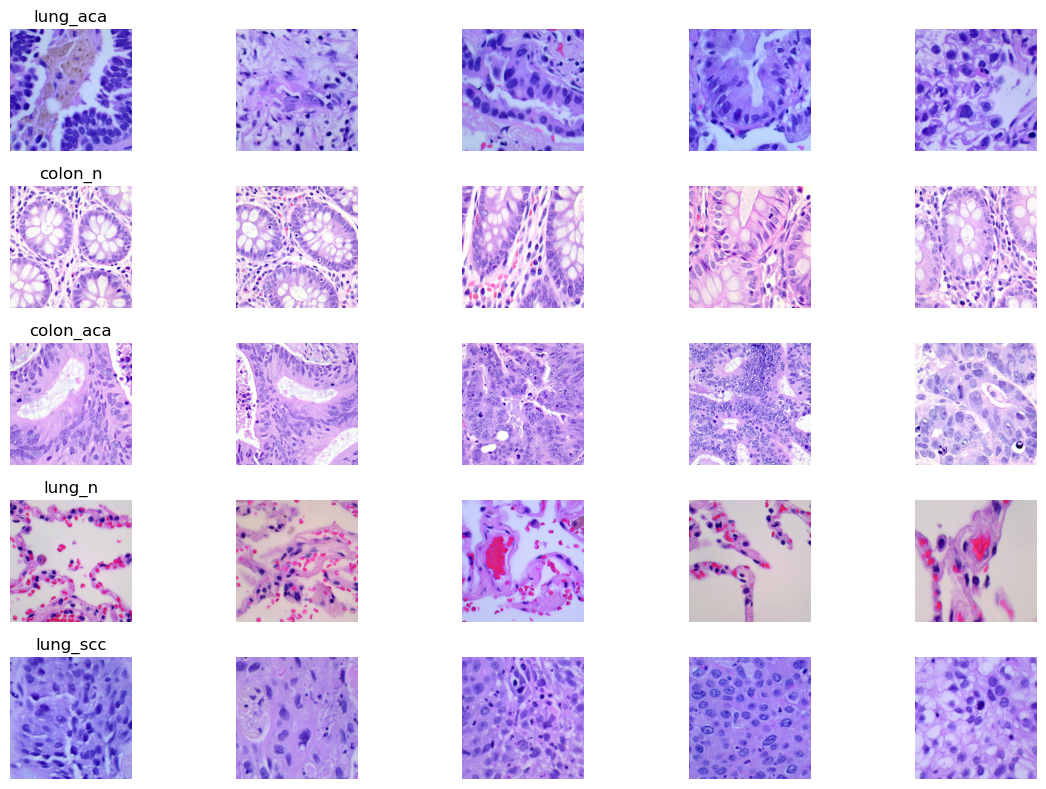

In [36]:
categories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

def show_sample_images(base_path, categories, num_samples=5):
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(12, 8))
    for i, category in enumerate(categories):
        folder_path = os.path.join(base_path, category)
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))][:num_samples]
        for j, img_name in enumerate(images):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(category)
    plt.tight_layout()
    plt.show()

show_sample_images(base_path, categories)

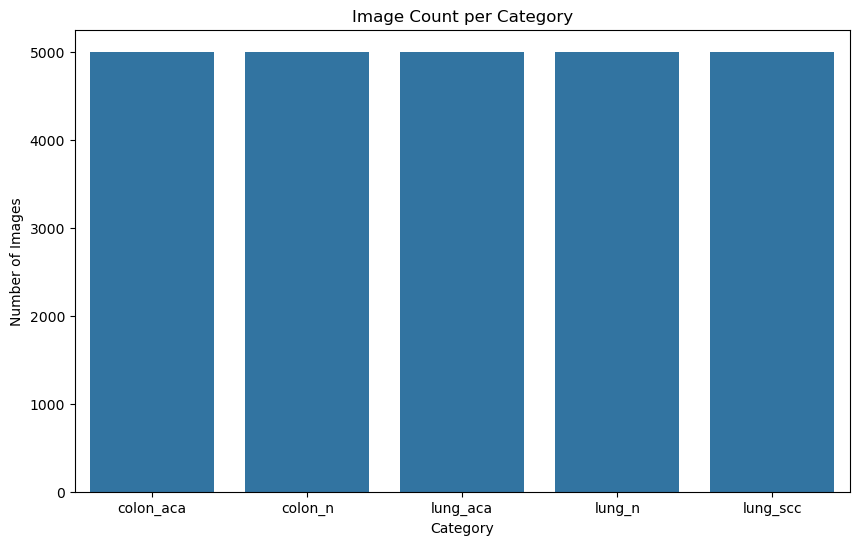

In [37]:
category_counts = {
    'colon_aca': len(os.listdir(os.path.join(base_path, 'colon_aca'))),
    'colon_n': len(os.listdir(os.path.join(base_path, 'colon_n'))),
    'lung_aca': len(os.listdir(os.path.join(base_path, 'lung_aca'))),
    'lung_n': len(os.listdir(os.path.join(base_path, 'lung_n'))),
    'lung_scc': len(os.listdir(os.path.join(base_path, 'lung_scc')))
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title('Image Count per Category')
plt.ylabel('Number of Images')
plt.xlabel('Category')
plt.show()


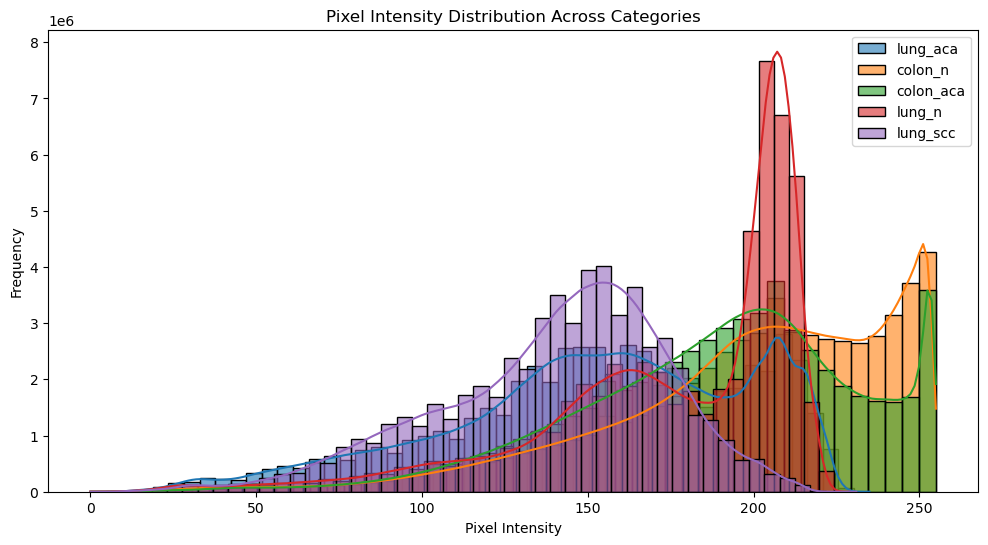

In [13]:
import random
import gc

def plot_pixel_intensity_distribution(base_path, categories, max_images_per_category=100):
    plt.figure(figsize=(12, 6))
    
    for category in categories:
        folder_path = os.path.join(base_path, category)
        img_names = os.listdir(folder_path)
        pixel_values = []

        sampled_images = random.sample(img_names, min(max_images_per_category, len(img_names)))

        for img_name in sampled_images:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                pixel_values.extend(img.flatten())

        sns.histplot(pixel_values, bins=50, kde=True, label=category, alpha=0.6)
        
        del pixel_values
        gc.collect()

    plt.title('Pixel Intensity Distribution Across Categories')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_pixel_intensity_distribution(base_path, categories)

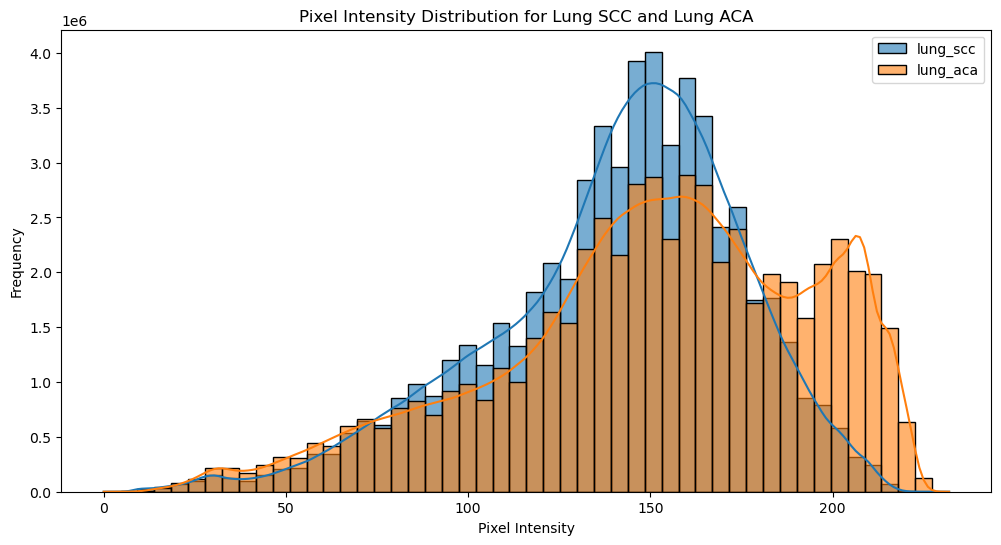

In [13]:
selected_categories = ['lung_scc', 'lung_aca']

def plot_pixel_intensity_distribution(base_path, categories, max_images_per_category=100):
    plt.figure(figsize=(12, 6))
    
    for category in categories:
        folder_path = os.path.join(base_path, category)
        img_names = os.listdir(folder_path)
        pixel_values = []

        sampled_images = random.sample(img_names, min(max_images_per_category, len(img_names)))

        for img_name in sampled_images:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                pixel_values.extend(img.flatten())

        sns.histplot(pixel_values, bins=50, kde=True, label=category, alpha=0.6)
        
        del pixel_values
        gc.collect()

    plt.title('Pixel Intensity Distribution for Lung SCC and Lung ACA')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_pixel_intensity_distribution(base_path, selected_categories)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, len(categories))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print(f"x_train shape: {np.array(x_train).shape}")
print(f"y_train shape: {np.array(y_train).shape}")
print(f"x_test shape: {np.array(x_test).shape}")
print(f"y_test shape: {np.array(y_test).shape}")

x_train shape: (18750, 150, 150, 3)
y_train shape: (18750, 5)
x_test shape: (6250, 150, 150, 3)
y_test shape: (6250, 5)


**Pretrained Model**

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

#Freeze
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0], IMG_SIZE, IMG_SIZE, 3)

x_test = np.array(x_test)
x_test = x_test.reshape(y_test.shape[0], IMG_SIZE, IMG_SIZE, 3)

#Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[CategoricalAccuracy()])

epochs = 10
batch_size = 64
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 256s 868ms/step - categorical_accuracy: 0.9093 - loss: 0.2792 - val_categorical_accuracy: 0.9778 - val_loss: 0.0587
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 246s 841ms/step - categorical_accuracy: 0.9806 - loss: 0.0534 - val_categorical_accuracy: 0.9782 - val_loss: 0.0616
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 246s 841ms/step - categorical_accuracy: 0.9868 - loss: 0.0342 - val_categorical_accuracy: 0.9893 - val_loss: 0.0279
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 247s 845ms/step - categorical_accuracy: 0.9886 - loss: 0.0294 - val_categorical_accuracy: 0.9906 - val_loss: 0.0251
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 246s 841ms/step - categorical_accuracy: 0.9909 - loss: 0.0225 - val_categorical_accuracy: 0.9896 - val_loss: 0.0276
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 247s 843ms/step - categorical_accuracy: 0.9928 - loss: 0.0204 - val_categorical_accuracy: 0.9939 - val_loss: 0.0191
Epoch 7/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 253s 863ms/step - catego

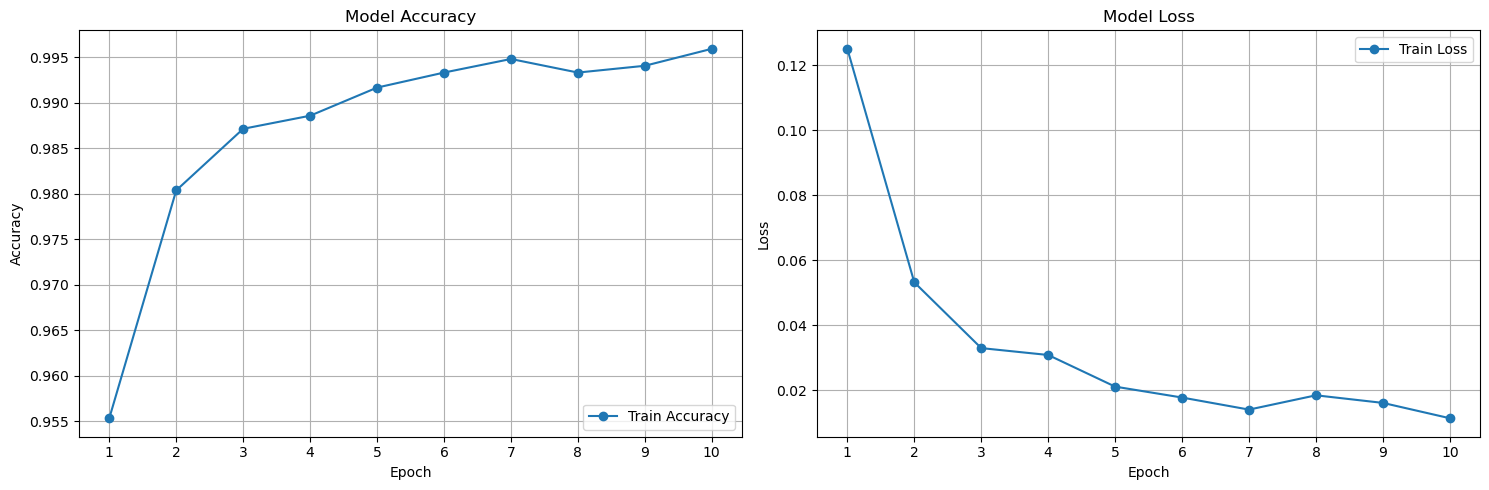

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#accuracy
ax1.plot(history.history['categorical_accuracy'], label='Train Accuracy', marker='o')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.set_xticks(range(0, 10)) 
ax1.set_xticklabels(range(1, 11)) 
ax1.grid(True)

#loss
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.set_xticks(range(0, 10))  
ax2.set_xticklabels(range(1, 11))  
ax2.grid(True)

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
import numpy as np

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100
precision = precision_score(y_true_classes, y_pred_classes, average='macro') *100
recall = recall_score(y_true_classes, y_pred_classes, average='macro') * 100
f1 = f1_score(y_true_classes, y_pred_classes, average='macro') * 100
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


#metrics
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

196/196 ━━━━━━━━━━━━━━━━━━━━ 71s 359ms/step
Accuracy: 99.54%
Precision: 99.53%
Recall: 99.53%
F1 Score: 99.53%


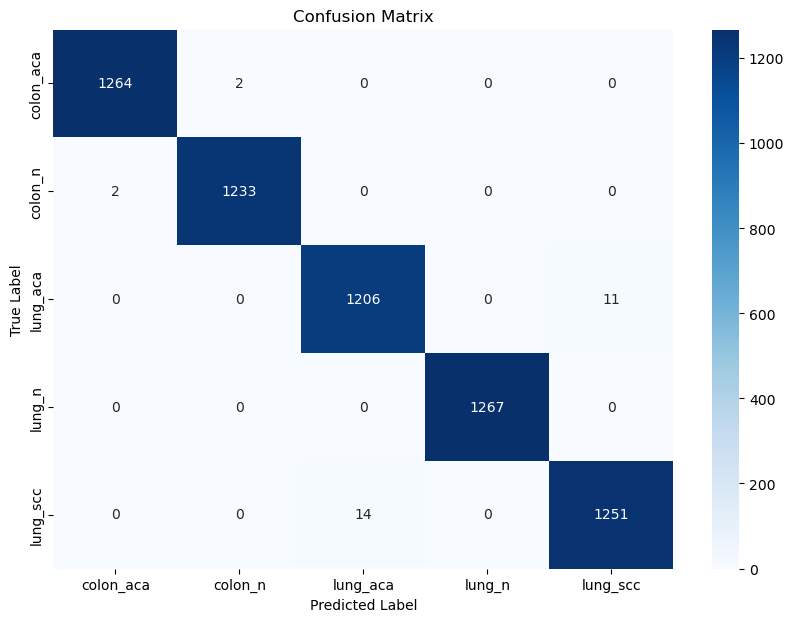

In [16]:
classes = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**CNN Model**

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [19]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train = x_train / 255.0
x_test = x_test / 255.0

In [20]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Dropout
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10, 
    batch_size=32
)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 153s 261ms/step - accuracy: 0.5217 - loss: 1.0262 - val_accuracy: 0.8251 - val_loss: 0.4643
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 148s 252ms/step - accuracy: 0.7592 - loss: 0.5484 - val_accuracy: 0.8432 - val_loss: 0.3740
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 137s 233ms/step - accuracy: 0.8141 - loss: 0.4407 - val_accuracy: 0.8685 - val_loss: 0.3282
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 140s 238ms/step - accuracy: 0.8549 - loss: 0.3750 - val_accuracy: 0.8574 - val_loss: 0.3153
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 139s 236ms/step - accuracy: 0.8746 - loss: 0.3214 - val_accuracy: 0.8738 - val_loss: 0.2789
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 135s 230ms/step - accuracy: 0.8802 - loss: 0.2973 - val_accuracy: 0.8970 - val_loss: 0.2304
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 129s 220ms/step - accuracy: 0.8966 - loss: 0.2648 - val_accuracy: 0.9128 - val_loss: 0.2116
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 129s 220ms/step - accuracy: 0.9065 -

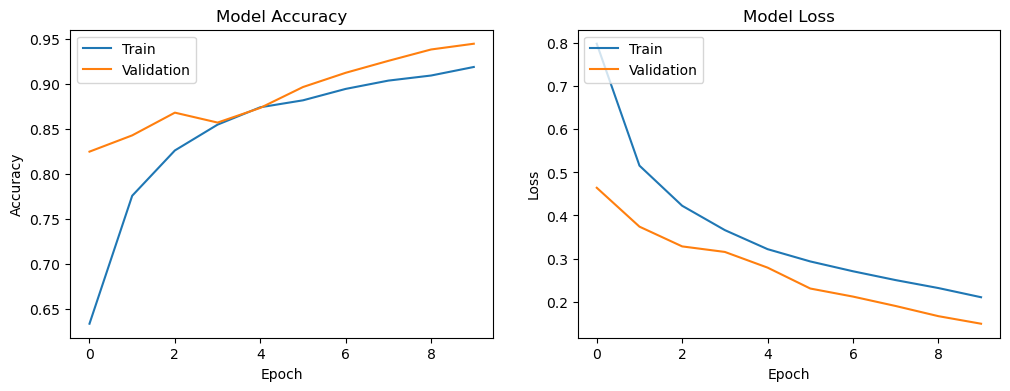

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [24]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step


In [25]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.9478
Recall: 0.9451
Accuracy: 0.9451


196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step


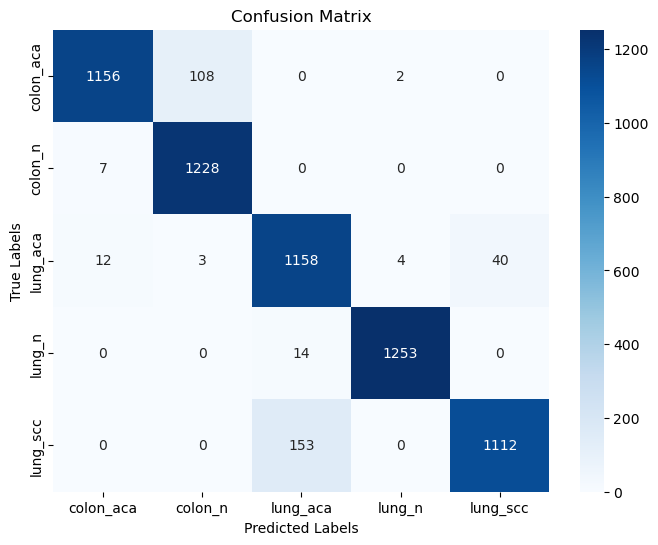

In [26]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Fine Tuning CNN Model**

In [28]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15,
    batch_size=32
)

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 134s 227ms/step - accuracy: 0.7685 - loss: 0.7089 - val_accuracy: 0.8179 - val_loss: 0.3577
Epoch 2/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 105s 179ms/step - accuracy: 0.8849 - loss: 0.2982 - val_accuracy: 0.9312 - val_loss: 0.1847
Epoch 3/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 106s 180ms/step - accuracy: 0.8984 - loss: 0.2685 - val_accuracy: 0.9392 - val_loss: 0.1669
Epoch 4/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 106s 181ms/step - accuracy: 0.9226 - loss: 0.2013 - val_accuracy: 0.9347 - val_loss: 0.1733
Epoch 5/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 105s 179ms/step - accuracy: 0.9247 - loss: 0.2054 - val_accuracy: 0.9514 - val_loss: 0.1325
Epoch 6/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 104s 178ms/step - accuracy: 0.9456 - loss: 0.1504 - val_accuracy: 0.9622 - val_loss: 0.1066
Epoch 7/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 106s 181ms/step - accuracy: 0.9556 - loss: 0.1176 - val_accuracy: 0.9658 - val_loss: 0.0946
Epoch 8/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 109s 186ms/step - accuracy: 0.9665 -

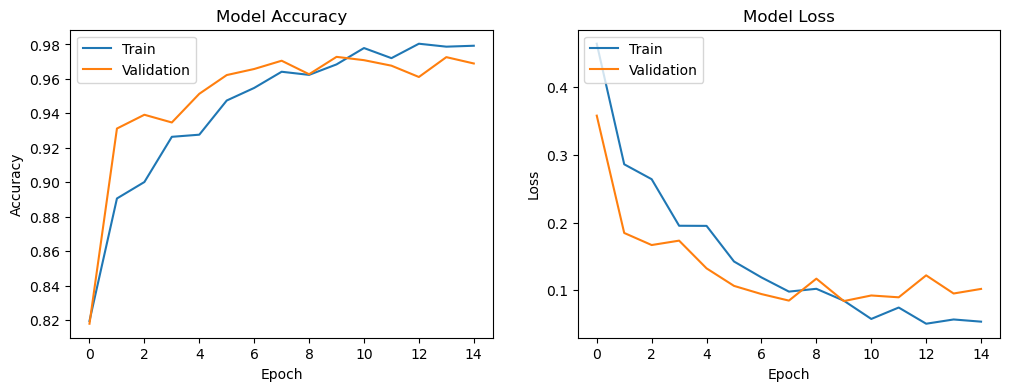

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [31]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step


In [32]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

#precision, recall, and accuracy
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)

#metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.9693
Recall: 0.9690
Accuracy: 0.9690


196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step


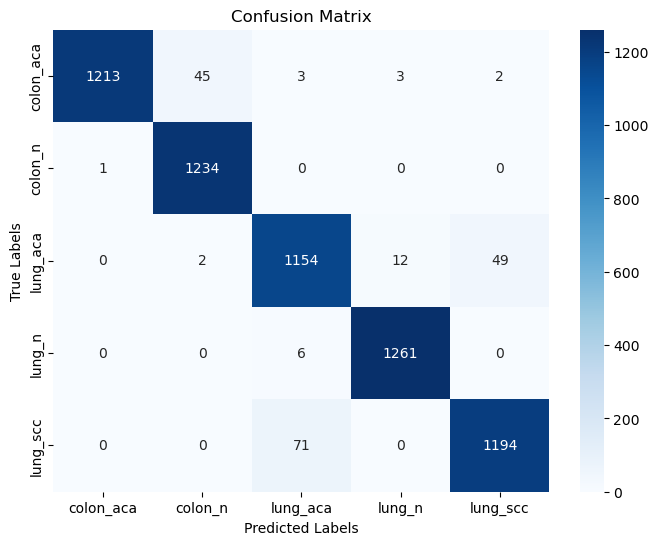

In [33]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**CSIP(Class-Specific Image Processing)**

In [2]:
import os
import cv2

base_path = '/Users/vamshisamudrala/Downloads/lung_colon_image_set'
processed_base_path = '/Users/vamshisamudrala/Desktop/lung_colon_image_set_processed'

os.makedirs(processed_base_path, exist_ok=True)

In [3]:
def enhance_contrast(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) 
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR) 

In [4]:
target_classes = ['lung_scc', 'lung_aca']

for category in target_classes:
    category_path = os.path.join(base_path, category)
    processed_category_path = os.path.join(processed_base_path, category)
    os.makedirs(processed_category_path, exist_ok=True)
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        if img is not None:
            enhanced_img = enhance_contrast(img)
  
            enhanced_img_path = os.path.join(processed_category_path, img_name)
            cv2.imwrite(enhanced_img_path, enhanced_img)
        else:
            print(f"Error reading image: {img_path}")

**Pre-defined model with Class-Specific Image Processing**

In [7]:
import os
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [8]:
original_data_path = '/Users/vamshisamudrala/Downloads/lung_colon_image_set'
processed_data_path = '/Users/vamshisamudrala/Desktop/lung_colon_image_set_processed'

In [9]:
categories = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

IMG_SIZE = (150, 150)

In [10]:
def load_images(categories, original_path, processed_path, img_size=(150, 150)):
    X, y = [], []
    for category in categories:
        if category in ['lung_scc', 'lung_aca']:
            folder_path = os.path.join(processed_path, category)
        else:
            folder_path = os.path.join(original_path, category)
        
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(categories.index(category)) 

    return np.array(X), np.array(y)

In [11]:
X, y = load_images(categories, original_data_path, processed_data_path, IMG_SIZE)

y = to_categorical(y, num_classes=len(categories))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data loaded and split successfully.")
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Data loaded and split successfully.
Training data shape: (20000, 150, 150, 3), Training labels shape: (20000, 5)
Testing data shape: (5000, 150, 150, 3), Testing labels shape: (5000, 5)


In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(len(categories), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 422ms/step - accuracy: 0.9292 - loss: 0.2039 - val_accuracy: 0.9782 - val_loss: 0.0593
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 417ms/step - accuracy: 0.9817 - loss: 0.0463 - val_accuracy: 0.9574 - val_loss: 0.0997
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 417ms/step - accuracy: 0.9834 - loss: 0.0436 - val_accuracy: 0.9846 - val_loss: 0.0398
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 280s 449ms/step - accuracy: 0.9867 - loss: 0.0350 - val_accuracy: 0.9790 - val_loss: 0.0617
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 417ms/step - accuracy: 0.9912 - loss: 0.0236 - val_accuracy: 0.9902 - val_loss: 0.0258
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 416ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.9882 - val_loss: 0.0340
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 423ms/step - accuracy: 0.9924 - loss: 0.0205 - val_accuracy: 0.9902 - val_loss: 0.0265
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 276s 442ms/step - accuracy: 0.9934 -

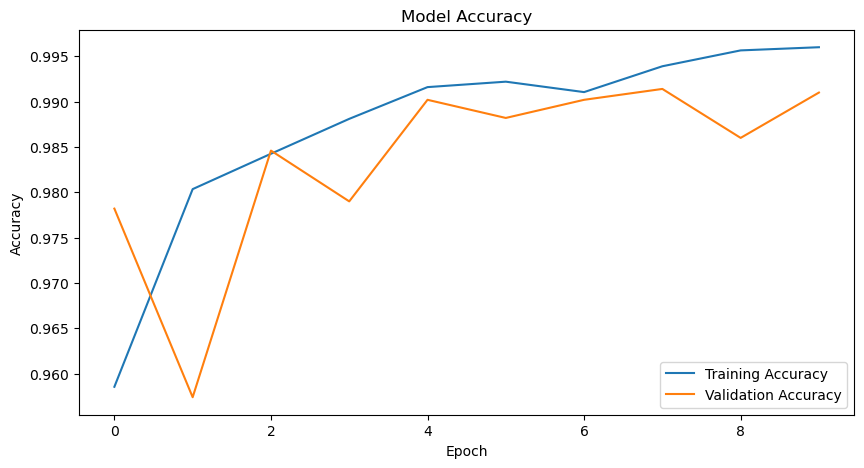

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1) 
class_names = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

print(classification_report(y_true, y_pred, target_names=class_names))

157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 329ms/step
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00      1021
     colon_n       1.00      1.00      1.00      1000
    lung_aca       0.99      0.97      0.98       985
      lung_n       1.00      1.00      1.00       989
    lung_scc       0.97      0.99      0.98      1005

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



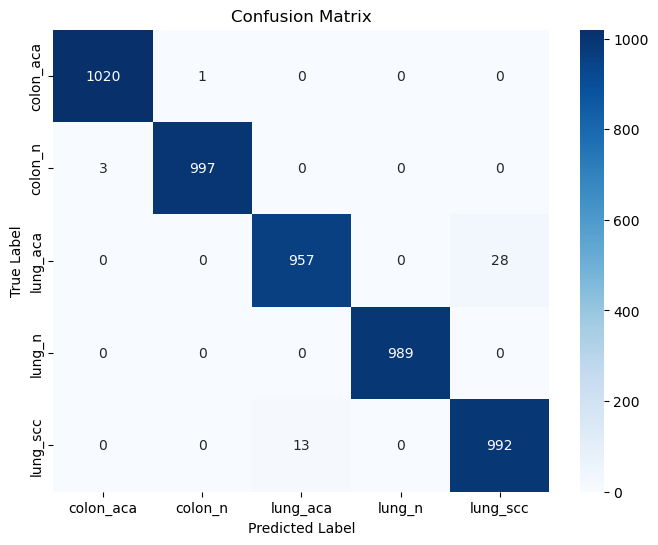

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**CSIP CNN Model**

In [3]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

base_path = '/Users/vamshisamudrala/Downloads/lung_colon_image_set'
processed_path = '/Users/vamshisamudrala/Desktop/lung_colon_image_set_processed'
IMG_SIZE = 150  

X = []
Z = []

In [4]:
def load_images_from_folder(folder, label):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            Z.append(label)

In [5]:
load_images_from_folder(os.path.join(base_path, 'colon_aca'), 0) 
load_images_from_folder(os.path.join(base_path, 'colon_n'), 1)   
load_images_from_folder(os.path.join(base_path, 'lung_n'), 2)     

load_images_from_folder(os.path.join(processed_path, 'lung_aca'), 3)  
load_images_from_folder(os.path.join(processed_path, 'lung_scc'), 4)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
X = np.array(X) / 255.0
Z = np.array(Z)

Z = to_categorical(Z, num_classes=5)

X_train, X_val, y_train, y_val = train_test_split(X, Z, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# Firstlayer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Secondlayer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Thirdlayer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatteninglayers
model.add(Flatten())

# Fullylayer
model.add(Dense(128, activation='relu'))

# Dropout
model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.6326 - loss: 0.7755 - val_accuracy: 0.8386 - val_loss: 0.3757
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 176ms/step - accuracy: 0.8450 - loss: 0.3592 - val_accuracy: 0.9326 - val_loss: 0.1873
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 170ms/step - accuracy: 0.9003 - loss: 0.2532 - val_accuracy: 0.9456 - val_loss: 0.1443
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 170ms/step - accuracy: 0.9324 - loss: 0.1761 - val_accuracy: 0.9522 - val_loss: 0.1253
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 171ms/step - accuracy: 0.9428 - loss: 0.1384 - val_accuracy: 0.9600 - val_loss: 0.1016
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 177ms/step - accuracy: 0.9638 - loss: 0.1023 - val_accuracy: 0.9448 - val_loss: 0.1407
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - accuracy: 0.9709 - loss: 0.0794 - val_accuracy: 0.9656 - val_loss: 0.0860
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.9725 -

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

   colon_aca       0.97      0.96      0.97      1021
     colon_n       0.97      0.97      0.97      1000
    lung_aca       0.99      1.00      1.00       985
      lung_n       0.98      0.83      0.90       989
    lung_scc       0.85      0.99      0.91      1005

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



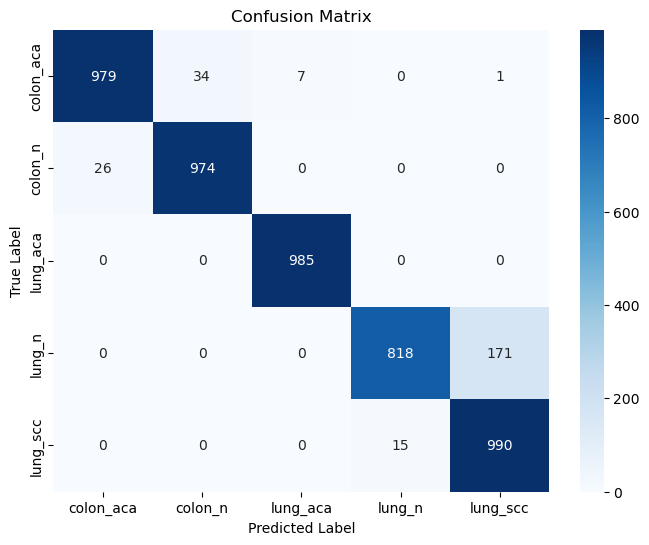

In [10]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**without hot encoding**

In [2]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_path = '/Users/vamshisamudrala/Downloads/lung_colon_image_set'
processed_path = '/Users/vamshisamudrala/Desktop/lung_colon_image_set_processed'
IMG_SIZE = 150 

X = []
Z = []

In [3]:
for label, class_name in enumerate(os.listdir(base_path)):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):  
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  
            X.append(img) 
            Z.append(label)  

In [4]:
X = np.array(X)
Z = np.array(Z)

X = X / 255.0

X_train, X_val, y_train, y_val = train_test_split(X, Z, test_size=0.2, random_state=42)

In [5]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels in y_train:", np.unique(y_train))

print("Check for NaNs in X_train:", np.isnan(X_train).any())
print("Check for NaNs in y_train:", np.isnan(y_train).any())

X_train shape: (20000, 150, 150, 3)
y_train shape: (20000,)
Unique labels in y_train: [1 2 3 4 5]
Check for NaNs in X_train: False
Check for NaNs in y_train: False


In [6]:
model = Sequential()

# Firstlayer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Secondlayer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Thirdlayer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatteninglayers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))

# Dropout
model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax'))


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1

history = model.fit(X_train, y_train_adjusted, epochs=10, validation_data=(X_val, y_val_adjusted), batch_size=32)

val_loss, val_accuracy = model.evaluate(X_val, y_val_adjusted)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.5841 - loss: 0.9269 - val_accuracy: 0.7626 - val_loss: 0.5353
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - accuracy: 0.7749 - loss: 0.5218 - val_accuracy: 0.8686 - val_loss: 0.3232
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 175ms/step - accuracy: 0.8296 - loss: 0.4104 - val_accuracy: 0.8780 - val_loss: 0.3055
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 174ms/step - accuracy: 0.8546 - loss: 0.3675 - val_accuracy: 0.8956 - val_loss: 0.2625
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 110s 176ms/step - accuracy: 0.8770 - loss: 0.3180 - val_accuracy: 0.8984 - val_loss: 0.2470
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 174ms/step - accuracy: 0.8813 - loss: 0.3006 - val_accuracy: 0.9024 - val_loss: 0.2321
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 174ms/step - accuracy: 0.8971 - loss: 0.2670 - val_accuracy: 0.9076 - val_loss: 0.2302
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 175ms/step - accuracy: 0.9057 -

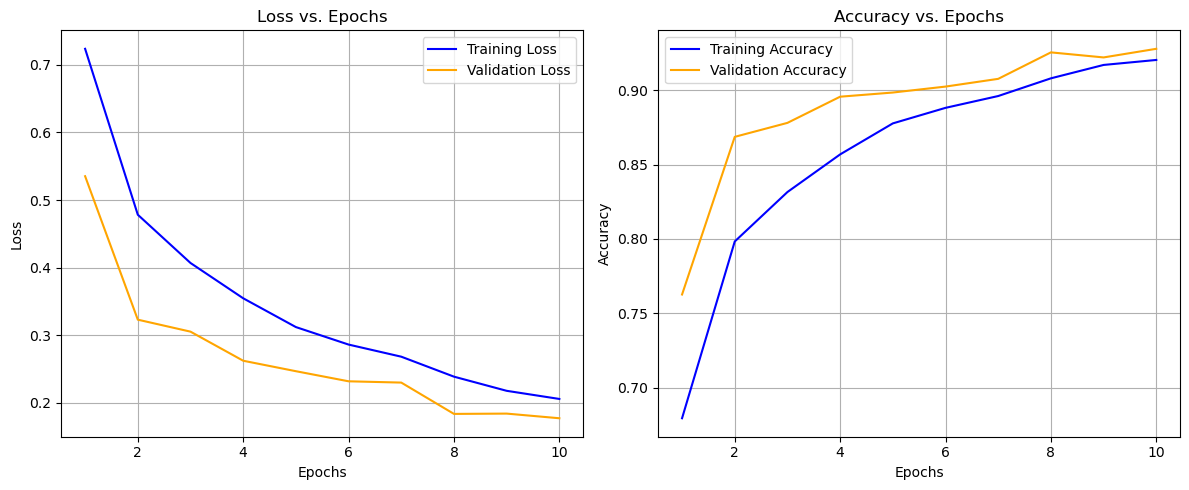

In [20]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [19]:
import numpy as np
from sklearn.metrics import classification_report

y_val_adjusted = y_val - 1 

y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1) 

print("Classification Report:")
print(classification_report(y_val_adjusted, y_val_pred_classes))


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1021
           1       0.95      0.91      0.93      1000
           2       0.90      0.95      0.92       985
           3       0.99      0.98      0.99       989
           4       0.87      0.96      0.91      1005

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


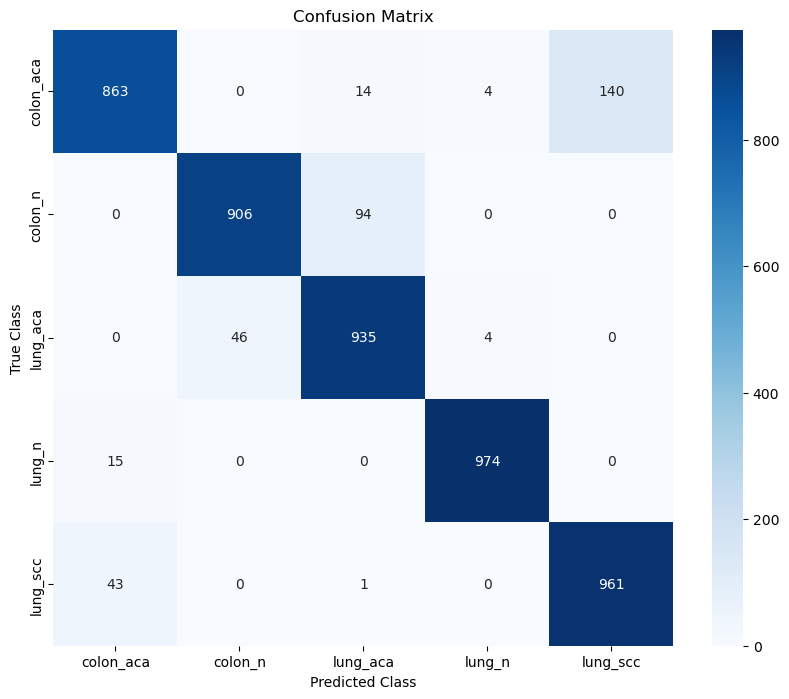

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(X_val), axis=-1)

cm = confusion_matrix(y_val_adjusted, y_pred)

class_names = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

**fine tuning**

In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1

history = model.fit(X_train, y_train_adjusted, epochs=15, validation_data=(X_val, y_val_adjusted), batch_size=32)

val_loss, val_accuracy = model.evaluate(X_val, y_val_adjusted)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 199ms/step - accuracy: 0.6399 - loss: 0.8106 - val_accuracy: 0.8596 - val_loss: 0.3192
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 178ms/step - accuracy: 0.8614 - loss: 0.3517 - val_accuracy: 0.9160 - val_loss: 0.2128
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.9065 - loss: 0.2439 - val_accuracy: 0.8986 - val_loss: 0.2461
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 170ms/step - accuracy: 0.9222 - loss: 0.2053 - val_accuracy: 0.9472 - val_loss: 0.1430
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step - accuracy: 0.9404 - loss: 0.1510 - val_accuracy: 0.9584 - val_loss: 0.1094
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 171ms/step - accuracy: 0.9500 - loss: 0.1361 - val_accuracy: 0.9492 - val_loss: 0.1427
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 170ms/step - accuracy: 0.9556 - loss: 0.1269 - val_accuracy: 0.9526 - val_loss: 0.1210
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 171ms/step - accuracy: 0.9627 -

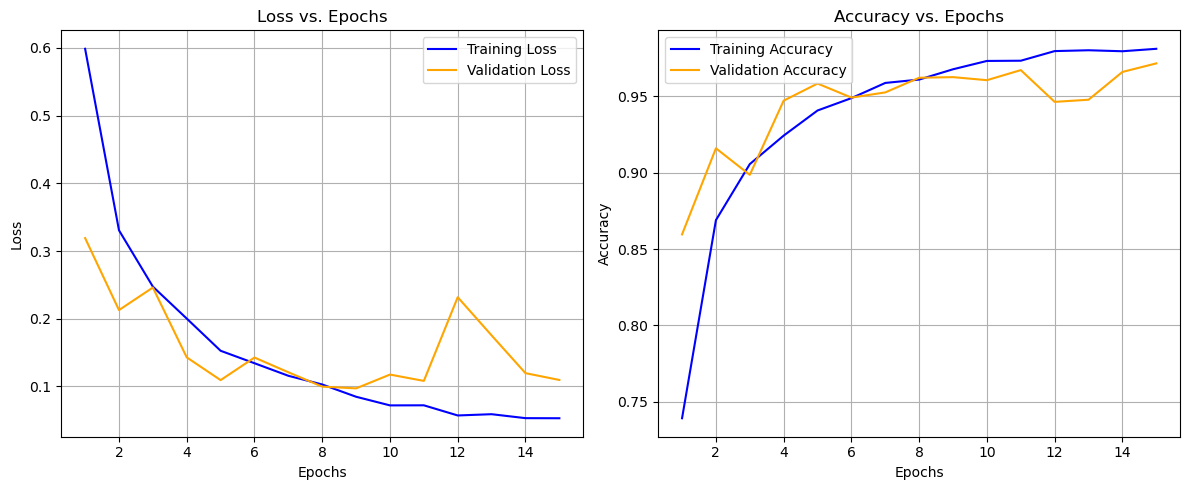

In [26]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plotting Loss vs. Epochs
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()


# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [27]:
import numpy as np
from sklearn.metrics import classification_report

y_val_adjusted = y_val - 1  

y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1) 

print("Classification Report:")
print(classification_report(y_val_adjusted, y_val_pred_classes))


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1021
           1       0.95      1.00      0.97      1000
           2       1.00      0.95      0.97       985
           3       0.99      1.00      0.99       989
           4       0.97      0.95      0.96      1005

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


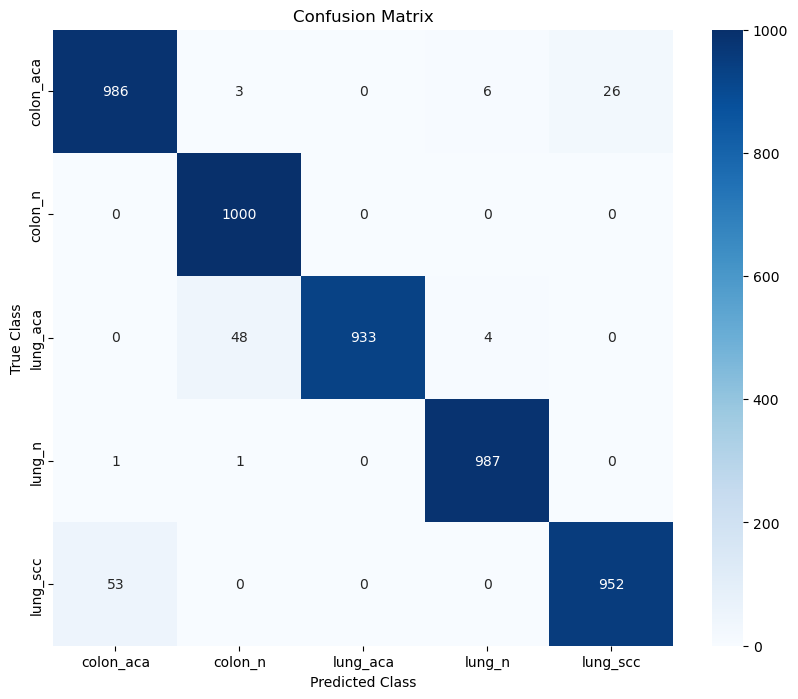

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(X_val), axis=-1)

cm = confusion_matrix(y_val_adjusted, y_pred)

class_names = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()